In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tifffile
from tqdm import tqdm
import glob
from pathlib import Path

In [3]:
image = tifffile.imread(".\\masks\\2D-1\\20230924 1141_xy29-2.tif")
image.shape

(3, 100, 100)

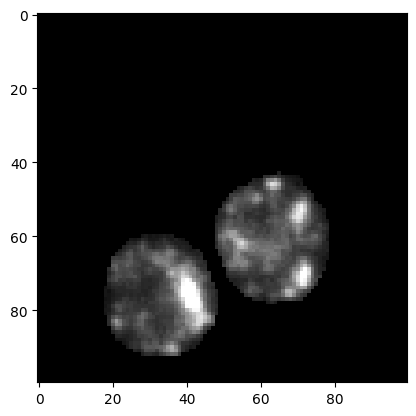

In [4]:
image_c1 = np.uint8(np.where(image[1]>0,1,0))
image_c1_3= cv2.cvtColor(image_c1 ,cv2.COLOR_GRAY2RGB)
image_c2_3= cv2.cvtColor(image[2] ,cv2.COLOR_GRAY2RGB)
image_c0 = image[2]*image_c1
image_c0_3 = cv2.cvtColor(image_c0 ,cv2.COLOR_GRAY2RGB)
plt.imshow(image_c0_3)

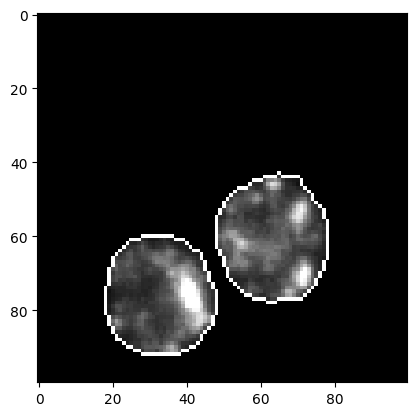

In [5]:
temp = np.uint8(cv2.cvtColor(image_c0,cv2.COLOR_GRAY2BGR))
contours, hierarchy = cv2.findContours(np.uint8(image[1]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_list = []
idx = 0
data = pd.DataFrame(columns=["id","total_intensity"])
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > 50:
        idx += 1
        copy = np.zeros_like(temp)
        cv2.drawContours(copy,[contours[i]],-1,(1,1,1),-1) #填充轮廓
        mask = copy*temp
        cv2.drawContours(mask,[contours[i]],-1,(255,255,255),1)
        total_intensity = mask.sum()
        area_list.append(mask)
        data.loc[len(data.index)] = (idx, total_intensity)

plt.imshow(np.uint8(sum(area_list)))

In [6]:
data

,id,total_intensity
0,1,267144
1,2,281454


# Batch process

In [7]:
def pol_process(category, filename, image, dataframe):
    # Process different channels.

    # Create a binary mask from channel 1 for further operations.
    image_cmask = np.uint8(np.where(image[1] > 0, 1, 0))  # Binary mask for channel 1.
    image_cmask_3 = cv2.cvtColor(image_cmask, cv2.COLOR_GRAY2RGB)  # Convert binary mask to 3-channel RGB.

    # Extract red fluorescence channel and prepare for processing.
    image_cred = image[2]  # Red fluorescence channel.
    image_cred_3 = cv2.cvtColor(image[2], cv2.COLOR_GRAY2RGB)  # Convert red channel to 3-channel RGB.

    # Mask the red fluorescence channel with the binary mask.
    image_cred0 = image_cmask * image_cred  # Apply binary mask to red channel.
    image_cred0_3 = cv2.cvtColor(image_cred0, cv2.COLOR_GRAY2RGB)  # Convert masked red channel to 3-channel RGB.

    # Prepare the masked red channel for contour processing.
    temp_red = np.uint8(cv2.cvtColor(image_cred0, cv2.COLOR_GRAY2BGR))

    # Find external contours using the binary mask.
    contours, hierarchy = cv2.findContours(image_cmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store processed red area masks and index counter.
    area_list_red = []
    idx = 0

    for i in range(len(contours)):
        # Process contours that have an area greater than 50.
        if cv2.contourArea(contours[i]) > 50:
            idx += 1  # Increment the index for each valid contour.

            # Create a blank mask for the current contour and fill it.
            copy_red = np.zeros_like(temp_red)
            cv2.drawContours(copy_red, [contours[i]], -1, (1, 1, 1), -1)  # Fill the contour.

            # Mask the red fluorescence for the current contour.
            mask_red = copy_red * temp_red

            # Draw the contour outline on the mask.
            cv2.drawContours(mask_red, [contours[i]], -1, (255, 255, 255), 1)

            # Calculate the total intensity of the red fluorescence within the contour.
            total_intensity = mask_red.sum()

            # Add the processed mask to the red area list.
            area_list_red.append(mask_red)

            # Append the metrics to the dataframe.
            dataframe.loc[len(dataframe.index)] = (category, filename, idx, total_intensity)

    return dataframe, total_intensity, area_list_red

In [10]:
dataframe = pd.DataFrame(columns=["category", "filename", "idx", "total_intensity"])

# Get a list of all .tif files in the ./masks/ directory and its subdirectories.
filepath_list = glob.glob("./masks/*/*.tif")

# Extract filenames and directory names from the file paths.
filename_list = [str(Path(i).parts[-1]) for i in filepath_list]
dir_list = [str(Path(i).parts[-2]) for i in filepath_list]

# Define a new directory to store processed results.
new_dir = "./process/"
!mkdir "./process/2D-1"

# Loop through each file in the list, displaying a progress bar with tqdm.
for i in tqdm(range(len(filename_list))):
    # Read the multi-channel image file.
    image = tifffile.imread(filepath_list[i])

    # Process the image and update the dataframe with the results.
    dataframe, total_intensity, area_list_red = pol_process(dir_list[i], filename_list[i], image, dataframe)

    # If there are valid processed areas, save the results.
    if len(area_list_red) != 0:
        # Combine the red masks into a single-channel image.
        red_image = cv2.cvtColor(sum(area_list_red), cv2.COLOR_RGB2GRAY)

        # Write the original binary mask and the processed red channel to the output directory.
        tifffile.imwrite("{}/{}/{}".format(new_dir, dir_list[i], filename_list[i]), np.uint8(image[0]), append=True)
        tifffile.imwrite("{}/{}/{}".format(new_dir, dir_list[i], filename_list[i]), np.uint8(red_image), append=True)

# Save the dataframe containing all processed information as a CSV file.
dataframe.to_csv(new_dir + "data.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.37it/s]


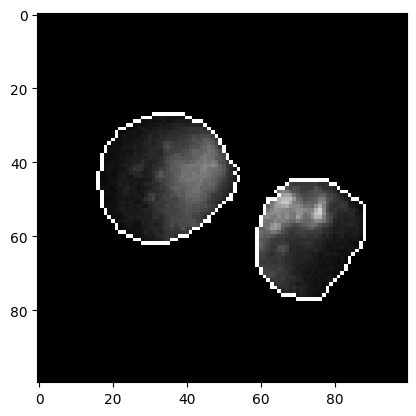

In [11]:
plt.imshow(sum(area_list_red))